<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
data_url = 'https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv'
data = pd.read_csv(data_url, parse_dates=['Time.Stamp'])
data = data[["Index", "Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [3]:
# Calculate speed and distances
epsilon = 1e-5
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data['Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + epsilon)

In [4]:
data


,Index,Tag,Latitude,Longitude,Time.Stamp,Time_diff,Lat_diff,Lon_diff,Speed
545,1067,5739,-13.097825,33.149230,2022-06-25 18:10:00,0.0,0.000000,0.000000e+00,0.000000e+00
575,1071,5739,-13.097773,33.149242,2022-06-25 18:45:00,2100.0,0.000052,1.200000e-05,2.541269e-08
594,1073,5739,-13.098073,33.145677,2022-06-25 19:15:00,1800.0,-0.000300,-3.565000e-03,1.987556e-06
629,1077,5739,-13.098188,33.145678,2022-06-25 19:45:00,1800.0,-0.000115,1.000000e-06,6.389130e-08
648,1079,5739,-13.105288,33.148128,2022-06-25 20:15:00,1800.0,-0.007100,2.450000e-03,4.172681e-06
...,...,...,...,...,...,...,...,...,...
378625,61230,5782,-13.210522,33.077262,2023-10-31 19:00:00,3600.0,0.000113,2.095000e-03,5.827904e-07
378656,61259,5782,-13.210608,33.080610,2023-10-31 20:00:00,3600.0,-0.000086,3.348000e-03,9.303068e-07
378687,61287,5782,-13.215273,33.076125,2023-10-31 21:01:00,3660.0,-0.004665,-4.485000e-03,1.768109e-06
378719,61315,5782,-13.210075,33.069102,2023-10-31 22:01:00,3600.0,0.005198,-7.023000e-03,2.427049e-06


In [5]:
# Categorize movements
def categorize_movement(df):
    conditions = [
        (df['Lat_diff'] == 0) & (df['Lon_diff'] == 0),
        (df['Lat_diff'] > 0),
        (df['Lat_diff'] < 0),
        (df['Lon_diff'] > 0),
        (df['Lon_diff'] < 0)
    ]
    choices = ['stationary', 'north', 'south', 'east', 'west']
    df['Movement'] = np.select(conditions, choices, default='stationary')
    return df

In [6]:
data = categorize_movement(data)

In [7]:
# Encode Movement Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Movement_Label'] = label_encoder.fit_transform(data['Movement'])


In [8]:
# Normalize features
scaler = MinMaxScaler()
data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']] = scaler.fit_transform(data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']])


In [9]:
# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data.iloc[i+sequence_length]['Movement_Label']
        sequences.append(seq[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']].values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 10
X, y = create_sequences(data, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)


In [11]:
# Define LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=5, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 5)  # Assuming 5 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return self.softmax(out)

In [12]:
# Initialize model, loss, and optimizer
model = LSTMClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [13]:
# Training and Validation Function
import torch

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs, save_path = "model_LSTM.pth"):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Model saved!")



# Run training and evaluation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
saved_model_path = "model_LSTM.pth"
model.load_state_dict(torch.load(saved_model_path))

Epoch 1/10, Train Loss: 1.5773, Train Accuracy: 0.4335, Val Loss: 1.5339, Val Accuracy: 0.4995
Model saved!
Epoch 2/10, Train Loss: 1.4908, Train Accuracy: 0.4986, Val Loss: 1.4502, Val Accuracy: 0.4995
Model saved!
Epoch 3/10, Train Loss: 1.4191, Train Accuracy: 0.4986, Val Loss: 1.3941, Val Accuracy: 0.4995
Model saved!
Epoch 4/10, Train Loss: 1.3793, Train Accuracy: 0.4986, Val Loss: 1.3682, Val Accuracy: 0.4995
Model saved!
Epoch 5/10, Train Loss: 1.3620, Train Accuracy: 0.4986, Val Loss: 1.3573, Val Accuracy: 0.4995
Model saved!
Epoch 6/10, Train Loss: 1.3543, Train Accuracy: 0.4986, Val Loss: 1.3521, Val Accuracy: 0.4995
Model saved!
Epoch 7/10, Train Loss: 1.3505, Train Accuracy: 0.4986, Val Loss: 1.3493, Val Accuracy: 0.4995
Model saved!
Epoch 8/10, Train Loss: 1.3484, Train Accuracy: 0.4984, Val Loss: 1.3477, Val Accuracy: 0.4995
Model saved!
Epoch 9/10, Train Loss: 1.3470, Train Accuracy: 0.4986, Val Loss: 1.3466, Val Accuracy: 0.4995
Model saved!
Epoch 10/10, Train Loss: 1.3

<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

        east       0.00      0.00      0.00        60
       north       0.00      0.00      0.00     37964
       south       0.50      1.00      0.67     38268
  stationary       0.00      0.00      0.00       255
        west       0.00      0.00      0.00        63

    accuracy                           0.50     76610
   macro avg       0.10      0.20      0.13     76610
weighted avg       0.25      0.50      0.33     76610

Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


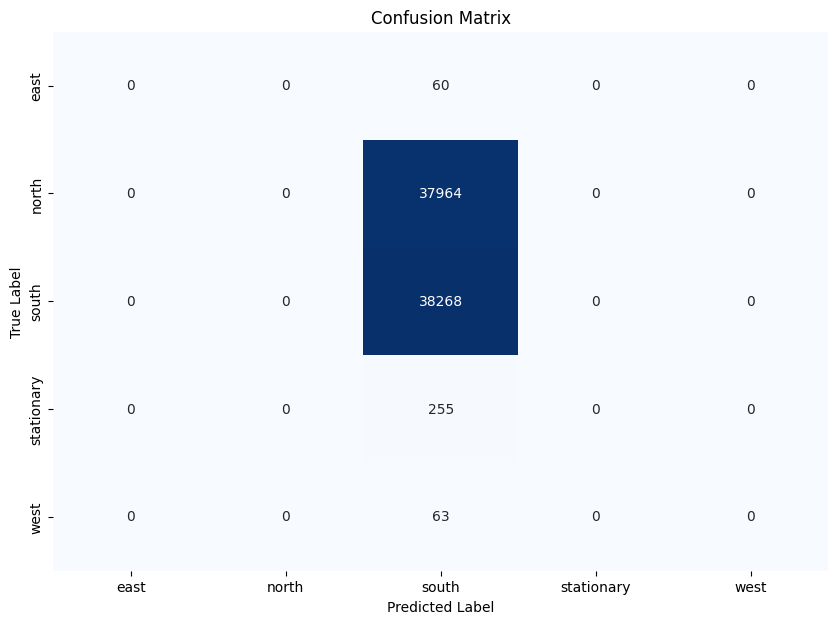

In [14]:
# Post-training analysis
all_y_pred, all_y_true = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_y_pred.extend(predicted.numpy())
        all_y_true.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size=5, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 5)  # Assuming 5 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return self.softmax(out)


In [16]:
# Initialize model, loss, and optimizer
model = GRUClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [19]:
# Training and Validation Function
import torch

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs, save_path = "model_GRU.pth"):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Model saved!")



# Run training and evaluation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
saved_model_path = "model_GRU.pth"
model.load_state_dict(torch.load(saved_model_path))

Epoch 1/10, Train Loss: 1.3436, Train Accuracy: 0.4979, Val Loss: 1.3436, Val Accuracy: 0.4987
Model saved!
Epoch 2/10, Train Loss: 1.3434, Train Accuracy: 0.4974, Val Loss: 1.3434, Val Accuracy: 0.4988
Model saved!
Epoch 3/10, Train Loss: 1.3433, Train Accuracy: 0.4982, Val Loss: 1.3433, Val Accuracy: 0.4988
Model saved!
Epoch 4/10, Train Loss: 1.3432, Train Accuracy: 0.4985, Val Loss: 1.3432, Val Accuracy: 0.4985
Model saved!
Epoch 5/10, Train Loss: 1.3431, Train Accuracy: 0.4993, Val Loss: 1.3431, Val Accuracy: 0.4995
Model saved!
Epoch 6/10, Train Loss: 1.3430, Train Accuracy: 0.4990, Val Loss: 1.3431, Val Accuracy: 0.5061
Model saved!
Epoch 7/10, Train Loss: 1.3430, Train Accuracy: 0.4985, Val Loss: 1.3431, Val Accuracy: 0.4955
Model saved!
Epoch 8/10, Train Loss: 1.3429, Train Accuracy: 0.4985, Val Loss: 1.3430, Val Accuracy: 0.4995
Model saved!
Epoch 9/10, Train Loss: 1.3429, Train Accuracy: 0.4982, Val Loss: 1.3430, Val Accuracy: 0.4986
Model saved!
Epoch 10/10, Train Loss: 1.3

<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

        east       0.00      0.00      0.00        60
       north       0.00      0.00      0.00     37964
       south       0.50      1.00      0.67     38268
  stationary       0.00      0.00      0.00       255
        west       0.00      0.00      0.00        63

    accuracy                           0.50     76610
   macro avg       0.10      0.20      0.13     76610
weighted avg       0.25      0.50      0.33     76610

Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


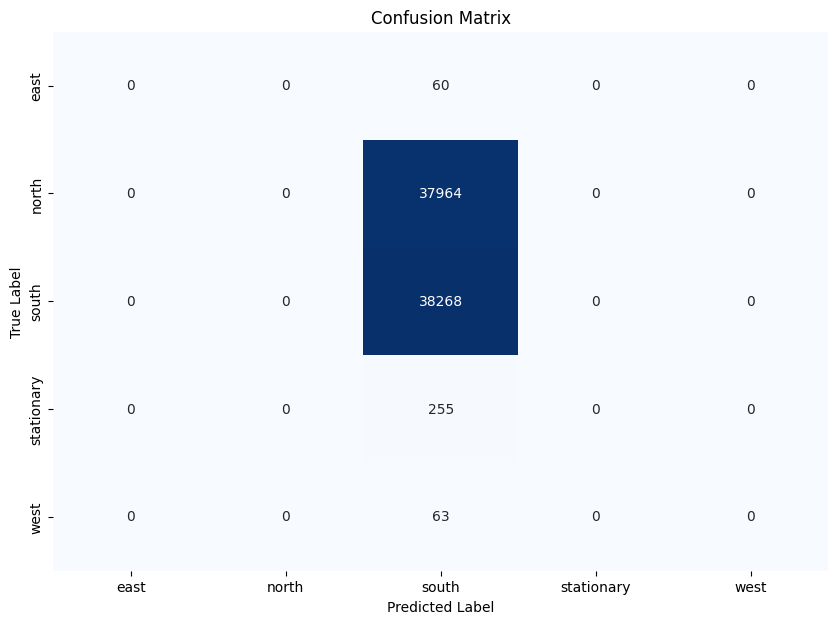

In [20]:
# Post-training analysis
all_y_pred, all_y_true = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_y_pred.extend(predicted.numpy())
        all_y_true.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
import torch.nn as nn

class SimpleRNNClassifier(nn.Module):
    def __init__(self):
        super(SimpleRNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size=5, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 5)  # Assuming 5 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return self.softmax(out)


In [22]:
# Initialize model, loss, and optimizer
model = SimpleRNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [23]:
# Training and Validation Function
import torch

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs, save_path = "model_SimpleRNN.pth"):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Model saved!")



# Run training and evaluation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
saved_model_path = "model_SimpleRNN.pth"
model.load_state_dict(torch.load(saved_model_path))

Epoch 1/10, Train Loss: 1.4039, Train Accuracy: 0.4947, Val Loss: 1.3477, Val Accuracy: 0.4994
Model saved!
Epoch 2/10, Train Loss: 1.3455, Train Accuracy: 0.4982, Val Loss: 1.3445, Val Accuracy: 0.4955
Model saved!
Epoch 3/10, Train Loss: 1.3439, Train Accuracy: 0.4993, Val Loss: 1.3437, Val Accuracy: 0.4995
Model saved!
Epoch 4/10, Train Loss: 1.3434, Train Accuracy: 0.4984, Val Loss: 1.3433, Val Accuracy: 0.4996
Model saved!
Epoch 5/10, Train Loss: 1.3431, Train Accuracy: 0.5000, Val Loss: 1.3431, Val Accuracy: 0.4995
Model saved!
Epoch 6/10, Train Loss: 1.3430, Train Accuracy: 0.4992, Val Loss: 1.3430, Val Accuracy: 0.4995
Model saved!
Epoch 7/10, Train Loss: 1.3429, Train Accuracy: 0.5006, Val Loss: 1.3429, Val Accuracy: 0.4991
Model saved!
Epoch 8/10, Train Loss: 1.3428, Train Accuracy: 0.4995, Val Loss: 1.3429, Val Accuracy: 0.5086
Model saved!
Epoch 9/10, Train Loss: 1.3428, Train Accuracy: 0.4998, Val Loss: 1.3428, Val Accuracy: 0.5099
Model saved!
Epoch 10/10, Train Loss: 1.3

<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

        east       0.00      0.00      0.00        60
       north       1.00      0.00      0.00     37964
       south       0.50      1.00      0.67     38268
  stationary       0.00      0.00      0.00       255
        west       0.00      0.00      0.00        63

    accuracy                           0.50     76610
   macro avg       0.30      0.20      0.13     76610
weighted avg       0.75      0.50      0.33     76610

Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


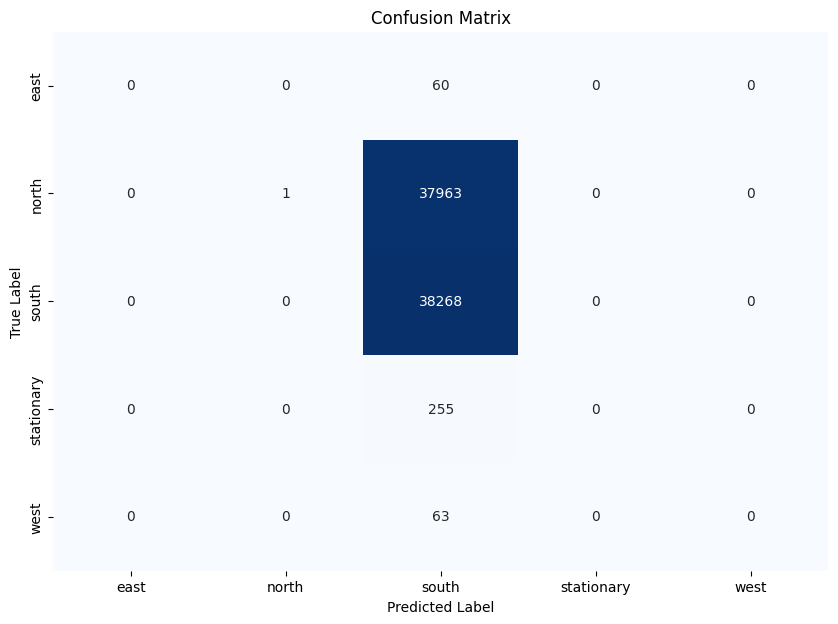

In [24]:
# Post-training analysis
all_y_pred, all_y_true = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_y_pred.extend(predicted.numpy())
        all_y_true.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()